# INSTALL SAM

In [ ]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

  Preparing metadata (setup.py) ... done


In [ ]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This 

### HOME constant

In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


### Download SAM weights

In [ ]:
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [ ]:
CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


# Download example data

In [ ]:
!mkdir -p {HOME}/data
# !wget -q https://drive.google.com/file/d/1J6nTfVy1uxx6ZyKQ1jknfqpQeAY9iwDs/view?usp=drive_link -P {HOME}/data

# LOAD MODEL

In [ ]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

In [ ]:
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

### Automatic Mask Generator

In [ ]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
# IMAGE_NAME = "IMG20230201123817_jpg.rf.9304ee8e18b71a57b48a5838732e6925_0_cropped.jpg"
IMAGE_NAME = "IMG20230201123817_jpg.rf.9304ee8e18b71a57b48a5838732e6925_0_cropped.jpg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

In [ ]:
import cv2
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
og_image = image_bgr
sam_result = mask_generator.generate(image_rgb)

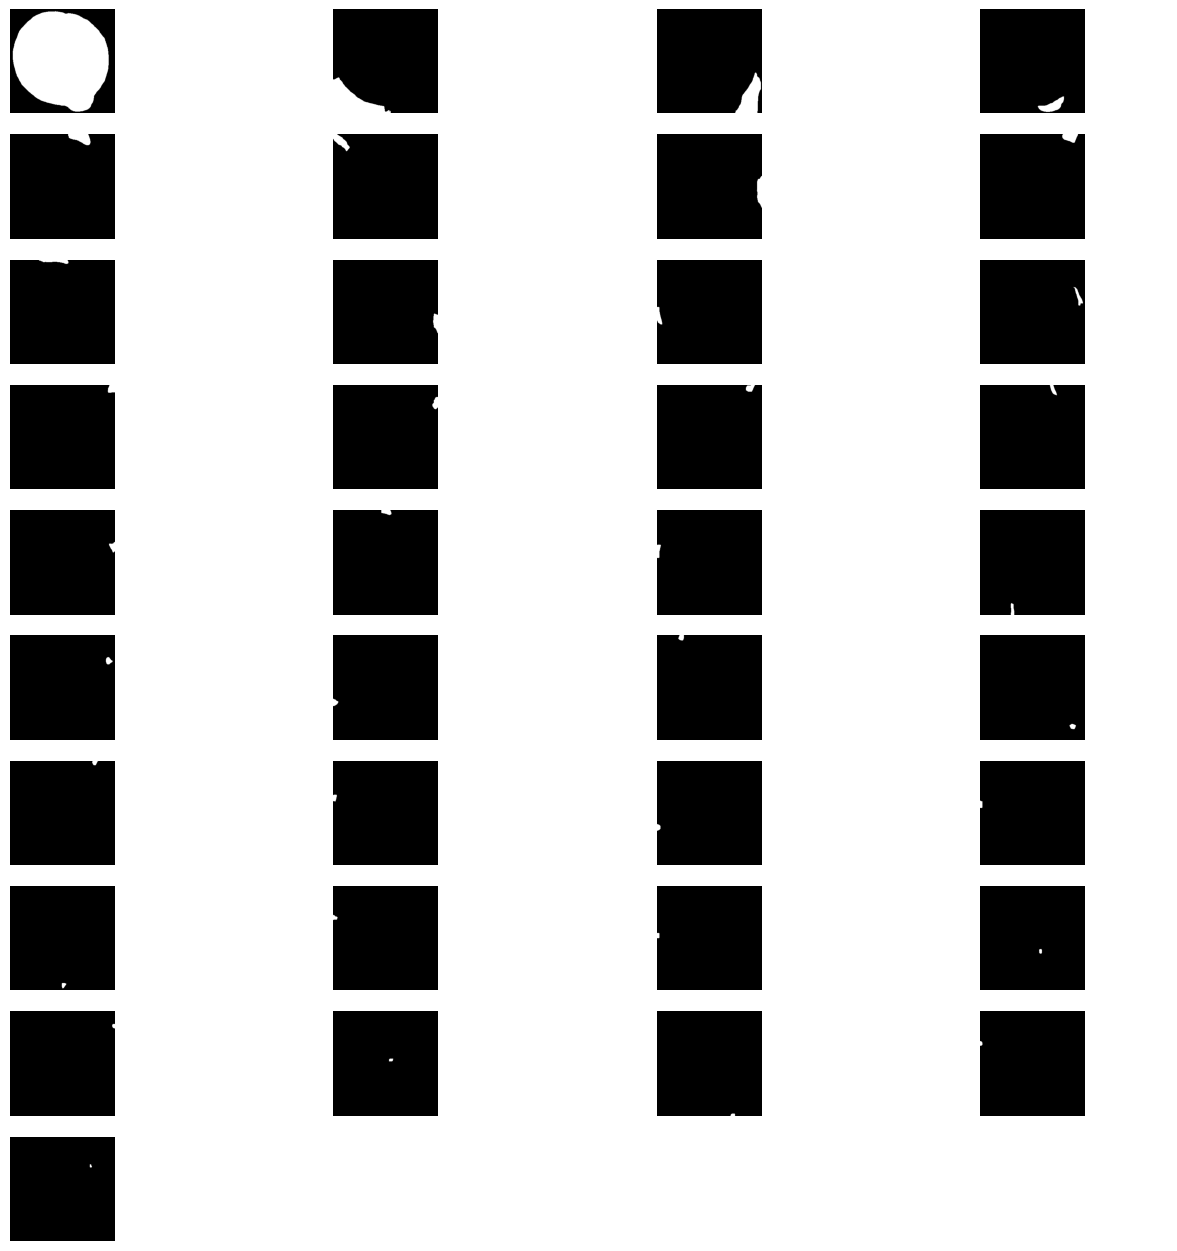

In [ ]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks,
    grid_size=(10, int(len(masks) / 8)),
    size=(16, 16)
)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab.patches import cv2_imshow
import numpy as np
print(type(masks[0]))

<class 'numpy.ndarray'>


In [ ]:
img_np_color = masks[0].astype(np.uint8)
mpimg.imsave('data/temp.png', img_np_color)

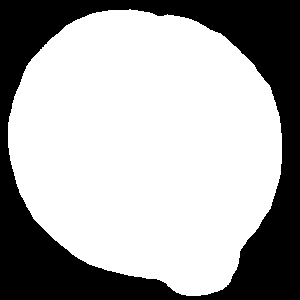

In [ ]:
img_cv2 = cv2.imread('data/temp.png')
# img_rgb = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2GRAY)
_, img_binary = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)
cv2_imshow(img_binary)

In [ ]:
white_background = np.ones_like(og_image) * 255
masked_image = cv2.bitwise_and(white_background, white_background, mask=cv2.bitwise_not(img_binary))
masked_image += cv2.bitwise_and(og_image, og_image, mask=img_binary)

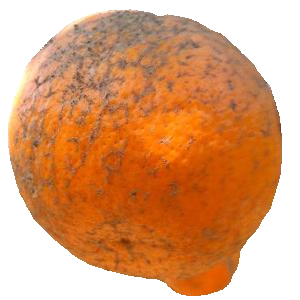

In [ ]:
cv2_imshow(masked_image)

In [ ]:
mask_predictor = SamPredictor(sam)

In [ ]:
import numpy as np

data = "1 0.503125 0.509375 0.1546875 0.1546875"
parts = data.split()
label = parts[0]
x, y, width, height = map(float, parts[1:])
image_size = 640

default_box = {'x': int(x * image_size - width * image_size / 2),
               'y': int(y * image_size - height * image_size / 2),
               'width': int(width * image_size),
               'height': int(height * image_size),
               'label': label}

# print(default_box)


# default_box = {'x': , 'y': , 'width': 640, 'height': 640, 'label': ''}

In [ ]:
box = default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

In [ ]:
image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

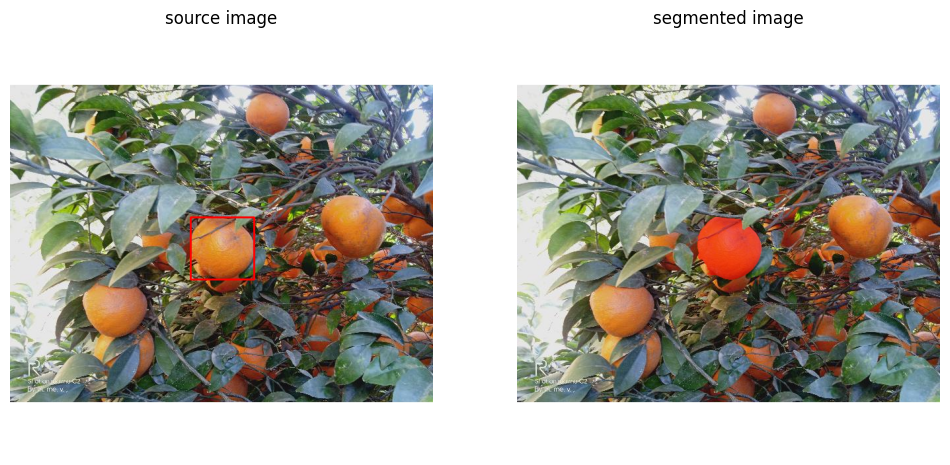

In [ ]:
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red(), color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

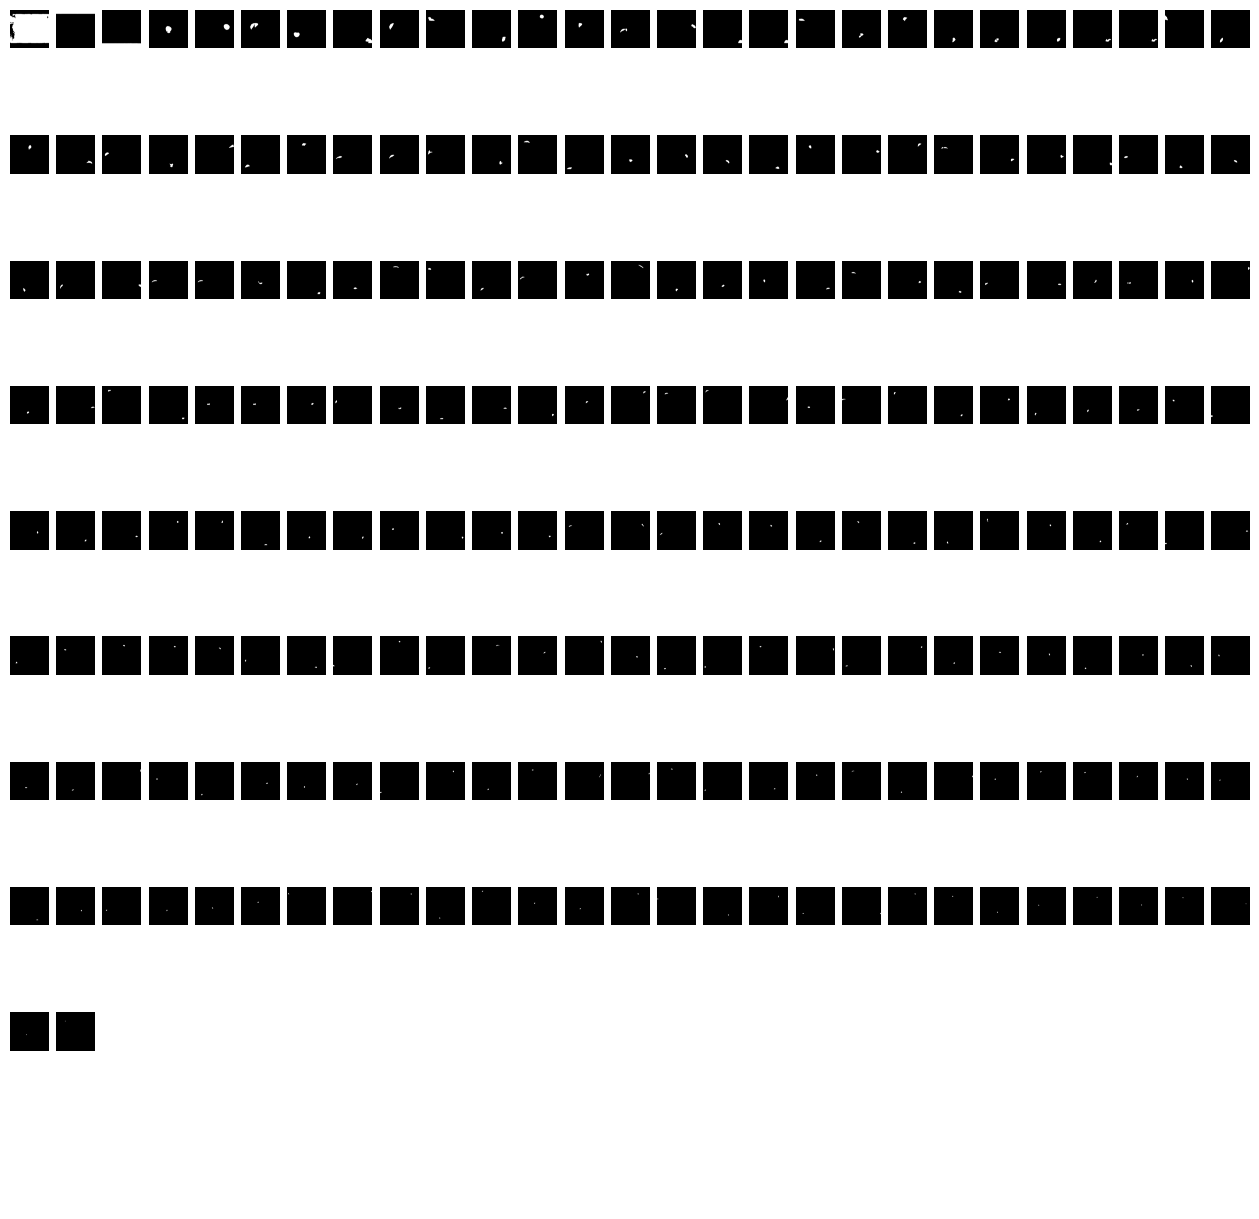

In [ ]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks,
    grid_size=(10, int(len(masks) / 8)),
    size=(16, 16)
)